In [38]:
import os
import numpy as np
import imageio
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from network import *
from tqdm.notebook import tqdm as tqdm

Dataset div2k


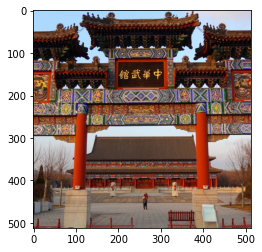

Dataset text


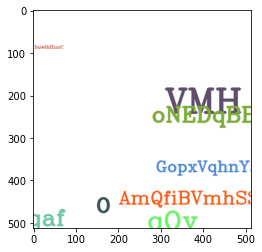

In [39]:
visualize = True #@param {type:"boolean"}

load_div2k = True #@param {type:"boolean"}
load_text = True #@param {type:"boolean"}

RES = 512

def load_dataset(filename, id):
    if not os.path.exists(filename):
        !gdown --id $id

    npz_data = np.load(filename)
    out = {
        "data_grid_search":npz_data['train_data'] / 255.,
        "data_test":npz_data['test_data'] / 255.,
    }
    return out

datasets = {}
if load_div2k:
    datasets['div2k'] = load_dataset('data_div2k.npz', '1TtwlEDArhOMoH18aUyjIMSZ3WODFmUab')
if load_text:
    datasets['text'] = load_dataset('data_2d_text.npz', '1V-RQJcMuk9GD4JCUn70o7nwQE0hEzHoT')

x1 = np.linspace(0, 1, RES//2+1)[:-1]
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)

x1_t = np.linspace(0, 1, RES+1)[:-1]
x_test = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)

def plot_dataset(dataset):
    plt.imshow(dataset['data_test'][0,:,:,:])
    plt.show()

if visualize:
    for dataset in datasets:
        print(f'Dataset {dataset}')
        plot_dataset(datasets[dataset])

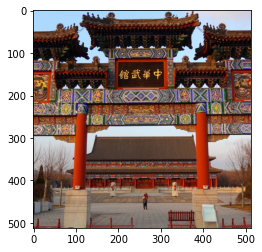

In [40]:
image = datasets['div2k']['data_test'][0,:,:,:]
plt.imshow(image)
plt.show()

## FFT expression

In [496]:
def fft_f(fscale):
    fx = torch.fft.fftfreq(int(512* fscale)) * fscale
#     fx = torch.fft.fftshift(fx)
    F_train = torch.stack(torch.meshgrid(fx.reshape(-1), fx.reshape(-1)), -1)
    F_train = F_train[:140,:140]
    return F_train

def rfft_2(image,dim=[40,40]):
    assert dim[-1]<= image.shape[1]//2+1
    F_0 = torch.fft.rfft(image,dim=1)[:,:dim[1]]
    F = torch.fft.fft(F_0,dim=0)#[:dim[0],:]
    F=torch.fft.fftshift(F,dim=0)[(image.shape[0]-dim[0])//2:(image.shape[0]+dim[0])//2]
    return torch.fft.fftshift(F,dim=0)

def irfft_2(F,dim_out=[512,512]):
    assert F.shape[0]<=dim_out[0]
    F=torch.fft.fftshift(F,dim=0)
    d_0,d_1=F.shape
    init_F = torch.zeros([dim_out[0],dim_out[1]//2+1],dtype=torch.cfloat).cuda()
    init_F[(dim_out[0]-d_0)//2:(dim_out[0]+d_0)//2,:d_1] = F 
    f_1 = torch.fft.ifft(torch.fft.ifftshift(init_F,dim=0),dim=0)
    f=torch.fft.irfft(f_1,dim=1)
    return f
   
def torch_irfft_2(F,dim_out=[512,512]):
    assert F.shape[0]<=dim_out[0]
    F=torch.fft.fftshift(F,dim=0)
    d_0,d_1=F.shape
    init_F = torch.zeros([dim_out[0],dim_out[1]//2+1],dtype=torch.cfloat).cuda()
    init_F[(dim_out[0]-d_0)//2:(dim_out[0]+d_0)//2,:d_1] = F 
    f = torch.fft.irfft2(torch.fft.ifftshift(init_F,dim=0),dim=[0,1])
    return f

def get_image(freq,model,volume_shape=[512,257,3]):
    out_ksp = model(freq.cuda().unsqueeze(0))[0]
    out_ksp = torch.stack([torch.view_as_complex(x) for x in torch.split(out_ksp,[2,2,2],dim=-1)],dim=-1)
    image=torch.stack([torch_irfft_2(F.squeeze()) for F in torch.split(out_ksp,[1,1,1],dim=-1)],dim=-1).real*1e+3
    return image

## build neural fft model

In [490]:
model = ImplicitNetwork(d_in=2,d_out=6,dims=[512, 512,512,512, 512,512],geometric_init=False,multires=100).cuda()
training_steps=100000
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=0,
)

image_gt=torch.from_numpy(image).cuda()

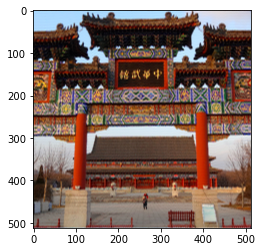

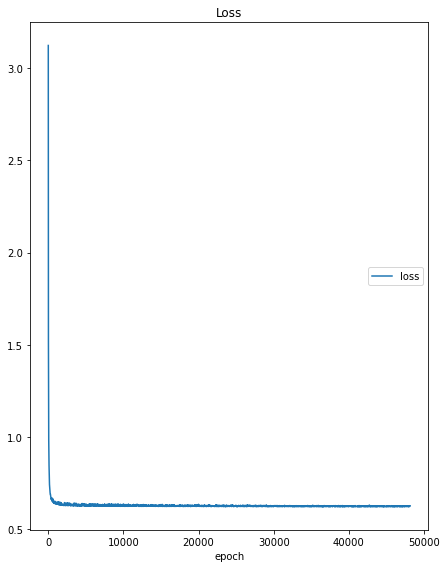

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss
	loss             	 (min:    0.623, max:    3.122, cur:    0.628)


In [ ]:
freq = fft_f(1.0)
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.0001,
#     weight_decay=0,
# )
plotlosses_model = PlotLosses()
for i in tqdm(range(training_steps), desc='train iter', leave=False):
    image_out = get_image(freq,model)
    loss = 5 * torch.mean((torch.abs(image_out-image_gt)).sum(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%20==0:
#         torch.save(model_kspace.state_dict(), "./checkpoints/model_kspace.pth")
        plotlosses_model.update({'loss':loss.item()}, current_step=i)
        plotlosses_model.send()
        plt.imshow(image_out.detach().cpu().numpy())

In [477]:
out_image=torch.stack([irfft_2(rfft_2(c.squeeze(),dim=[512,257])) for c in torch.split(image_gt,1,dim=-1)],dim=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


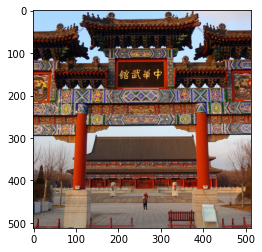

In [478]:
plt.imshow(out_image.cpu().numpy())
plt.show()